In [2]:
# Example python program to read data from a PostgreSQL table

# and load into a pandas DataFrame

import psycopg2

import pandas as pd

from sqlalchemy import create_engine

In [3]:
dbUser = "postgres"
dbPassword = "postgres"
dbHostname = "localhost"
dbPort = 5432
dbName = "tinkoff"

connectionString = "postgresql://%s:%s@%s:%d/%s?sslmode=disable" % (dbUser, dbPassword, dbHostname, dbPort, dbName)
# Create an engine instance
alchemyEngine = create_engine(connectionString, pool_recycle=3600);

In [4]:
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
df = pd.read_sql("""
SELECT name, instrument.id, figi, ts, open_price, close_price, high_price, low_price, volume
FROM candle
LEFT JOIN instrument
 ON candle.instrument_id=instrument.id
WHERE instrument.id < 4""", dbConnection);

pd.set_option('display.expand_frame_repr', False);

# Close the database connectio
dbConnection.close();

# Print the DataFrame
df.shape

(85897, 9)

In [5]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-02-08 20:45:00+00:00,108.96,108.57,108.99,108.57,960.0
1,JPMorgan,1,BBG000DMBXR2,2018-02-08 20:30:00+00:00,109.44,109.44,109.44,109.44,300.0
2,Bank of America Corp,3,BBG000BCTLF6,2018-02-08 20:45:00+00:00,29.76,29.76,29.76,29.76,800.0
3,JPMorgan,1,BBG000DMBXR2,2018-02-09 21:00:00+00:00,110.17,110.17,110.17,110.17,2.0
4,JPMorgan,1,BBG000DMBXR2,2018-02-09 20:45:00+00:00,110.20,110.12,110.89,109.92,73128.0


In [170]:
df_data_set = pd.DataFrame()

metric_names = ['open_price','close_price','high_price','low_price','volume']

for metric_name in metric_names:
    # Pivot table and create data set part with single metric
    df_buf = df.pivot(index='ts', columns='id')[metric_name]
    
    # Rename column
    df_buf.columns = ['%s_%d' % (metric_name, x) for x in df_buf.columns]
    
    # Concat dataset
    df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Add timestamp features
df_data_set['year'] = df_data_set.index.year
df_data_set['month'] = df_data_set.index.month
df_data_set['day'] = df_data_set.index.day
df_data_set['weekday'] = df_data_set.index.weekday
df_data_set['hour'] = df_data_set.index.hour
df_data_set['minute'] = df_data_set.index.minute


# Add target column
target_name = 'open_price'
# Pivot table and create data set part with single metric
df_buf = df.pivot(index='ts', columns='id')[target_name]
# Add target metric
df_buf = df_buf.shift(-1)
# Rename column
df_buf.columns = ['target_%d' % x for x in df_buf.columns]
# Concat dataset
df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)


# Fill NAN
df_data_set = df_data_set.fillna(method='ffill')

# Remove nan
df_data_set = df_data_set.dropna()

print(df_data_set.shape)
df_data_set.head()

(33770, 24)


,open_price_1,open_price_2,open_price_3,close_price_1,close_price_2,close_price_3,high_price_1,high_price_2,high_price_3,low_price_1,...,volume_3,year,month,day,weekday,hour,minute,target_1,target_2,target_3
ts,,,,,,,,,,,,,,,,,,,,,
2018-04-05 22:00:00+00:00,111.88,200.77,30.36,111.88,200.77,30.36,111.88,200.77,30.36,111.88,...,1000.0,2018,4,5,3,22,0,111.50,200.50,30.33
2018-04-05 22:45:00+00:00,111.50,200.50,30.33,111.50,200.50,30.22,111.50,200.50,30.33,111.50,...,1548.0,2018,4,5,3,22,45,111.09,199.25,30.02
2018-04-05 23:00:00+00:00,111.09,199.25,30.02,110.81,199.00,29.94,111.09,199.25,30.02,110.81,...,1058.0,2018,4,5,3,23,0,110.09,198.50,30.02
2018-04-05 23:15:00+00:00,110.09,198.50,30.02,110.09,198.50,29.94,110.09,198.50,30.02,110.09,...,1058.0,2018,4,5,3,23,15,110.09,198.50,29.92
2018-04-05 23:30:00+00:00,110.09,198.50,29.92,110.09,198.25,29.95,110.09,198.50,29.95,110.09,...,5625.0,2018,4,5,3,23,30,110.09,199.21,29.92


<AxesSubplot:xlabel='ts'>

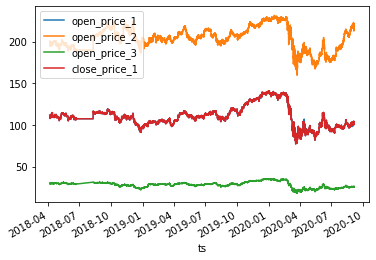

In [171]:
df_data_set.iloc[:,:4].plot()

# Neural network

In [172]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import numpy as np

import matplotlib.pyplot as plt

In [185]:
X_size = ((df_data_set.shape[1] - 6) // len(metric_names)) * len(metric_names) + 6
y_size = df_data_set.shape[1] - X_size


# Cut features and targets
X = df_data_set.iloc[:,:X_size]
y = df_data_set.iloc[:,X_size:X_size+y_size]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# scale inputs with MinMaxScaler()
input_scaler =  MinMaxScaler()
# fit scaler
input_scaler.fit(X_train)
# transform training dataset
X_train = input_scaler.transform(X_train)
# transform test dataset
X_test = input_scaler.transform(X_test)

# Transform output with MinMaxScaler()
output_scaler = MinMaxScaler()
# fit scaler on training dataset
output_scaler.fit(y_train)
# transform training dataset
y_train = output_scaler.transform(y_train)
# transform test dataset
y_test = output_scaler.transform(y_test)

# Reshape and create loopback
look_back = 50

def reshape_with_look_back(look_back, dataset):
    output = np.ndarray(((dataset.shape[0] - look_back), look_back + 1, dataset.shape[1]))

    for i in range(look_back, dataset.shape[0]):
        output[i-look_back] = dataset[i-look_back:i+1]

    return output

# Create look back for input
X_train = reshape_with_look_back(look_back, X_train)
X_test = reshape_with_look_back(look_back, X_test)

# Adopt look back for output
y_train = y_train[look_back:]
y_test = y_test[look_back:]

# TODO Add forward days
foward_days = 50

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22575, 51, 21)
(22575, 3)
(11095, 51, 21)
(11095, 3)


Train on 22575 samples, validate on 11095 samples
Epoch 1/10
 - 24s - loss: 0.0042 - acc: 0.8410 - val_loss: 0.0050 - val_acc: 0.7133
Epoch 2/10
 - 22s - loss: 1.9096e-04 - acc: 0.9195 - val_loss: 0.0029 - val_acc: 0.8762
Epoch 3/10
 - 22s - loss: 1.5252e-04 - acc: 0.9383 - val_loss: 0.0024 - val_acc: 0.8909
Epoch 4/10
 - 23s - loss: 1.3952e-04 - acc: 0.9432 - val_loss: 0.0020 - val_acc: 0.8818
Epoch 5/10
 - 22s - loss: 1.3356e-04 - acc: 0.9406 - val_loss: 0.0015 - val_acc: 0.8914
Epoch 6/10
 - 22s - loss: 1.2527e-04 - acc: 0.9434 - val_loss: 0.0013 - val_acc: 0.9109
Epoch 7/10
 - 22s - loss: 1.1659e-04 - acc: 0.9415 - val_loss: 0.0011 - val_acc: 0.9115
Epoch 8/10
 - 26s - loss: 1.0975e-04 - acc: 0.9471 - val_loss: 0.0012 - val_acc: 0.9116
Epoch 9/10
 - 23s - loss: 1.0944e-04 - acc: 0.9410 - val_loss: 0.0011 - val_acc: 0.9171
Epoch 10/10
 - 26s - loss: 1.0414e-04 - acc: 0.9413 - val_loss: 0.0010 - val_acc: 0.9036


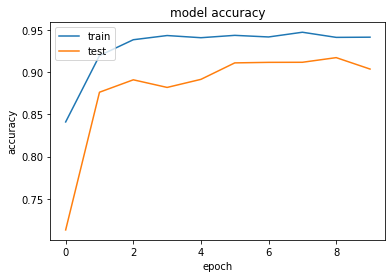

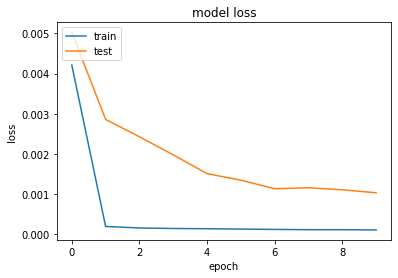

In [186]:
#Build the model
model = keras.Sequential()
model.add(layers.LSTM(100, input_shape=(look_back + 1,X_size), return_sequences=True))
model.add(layers.LSTM(50, input_shape=(100,1)))
model.add(layers.Dense(y_size))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),shuffle=True,batch_size=100, verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

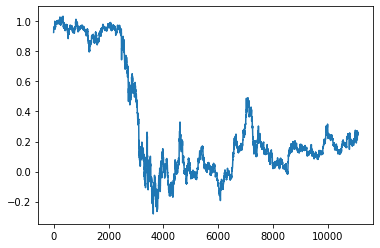

In [191]:
plt.plot(y_test[:,0])

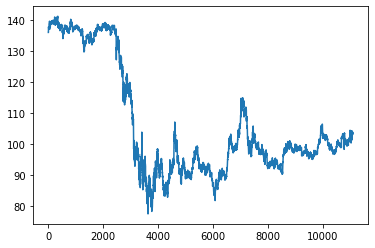

In [192]:
plt.plot(output_scaler.inverse_transform(y_test)[:,0])

In [189]:
y_pred_test = model.predict(X_test)

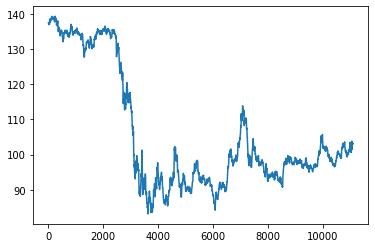

In [190]:
plt.plot(output_scaler.inverse_transform(y_pred_test)[:,0])